In [1]:
# SDI image gallery & analysis
import glob
import numpy as np
import astropy.io.fits as fits
import matplotlib.pylab as plt
from pyklip.klip import nan_gaussian_filter

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch, SinhStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [2]:
# plotting functions
def create_circular_mask(h, w, center=None, radius=None, leq=False):

    if center is None:  # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    if leq is False:
        return dist_from_center >= radius
    else:
        return dist_from_center <= radius


def domask(img, inn=70, outt=180):
    outermask = create_circular_mask(img.shape[0], img.shape[1], radius=outt, leq=True)
    img[~outermask] = np.nanmedian(img)
    mask = create_circular_mask(img.shape[0], img.shape[1], radius=inn)
    masked_img = img.copy()
    masked_img[~mask] = np.nanmedian(img)
    return masked_img

def trim_axs(axs, N):
    """conform the axs list to have correct length"""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [3]:
import seaborn as sns
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'
sns.set_context("talk")

In [4]:
scalefactordict = {'11Apr13':0.98,'8Apr14':1.19,#'8Apr14_long':0.88,
                   '15May15':1.16, '16May15':1.18, '18May15':1.22,
                   #'10Feb17':1.82, 
                   '27Apr18':1.22}

innouttdict = {'11Apr13':[7,14],'8Apr14':[7,20],#'8Apr14_long':0.88,
                   '15May15':[7,20], '16May15':[7,20], '18May15':[7,20],
                   #'10Feb17':1.82, 
                   '27Apr18':[3,18]}

dates = list(scalefactordict.keys())

In [5]:
platescale=7.95
platescale_err=0.10

def pix2arc(x):
    return (x-225) * platescale


def arc2pix(x):
    return (x / platescale)+225

def negpix2arc(x):
    return -(x-225) * platescale


def negarc2pix(x):
    return -(x / platescale)+225

In [6]:
from photutils.aperture import CircularAperture
preds = [(82,126.3),(77.2,116.6),(69,110.2),(69,110.2),(69,110.2),(44,55.4)]
pixpreds = []
for pred in preds:
    sep, pa = pred
    pa += 90
    r = sep/platescale
    x = r*np.cos(np.deg2rad(pa)) + 225
    y = r*np.sin(np.deg2rad(pa)) + 225
    pixpreds.append((x,y))
print(pixpreds)

[(216.68728061077002, 218.89370054571873), (216.31714376301898, 220.65194948664742), (216.854588859068, 222.00307223510706), (216.854588859068, 222.00307223510706), (216.854588859068, 222.00307223510706), (220.44427670245088, 228.14278299148887)]


In [7]:
def Reverse(lst):
    return [ele for ele in reversed(lst)]

In [8]:
dates2 = dates[0:3]+dates[5:]
print(dates2)

['11Apr13', '8Apr14', '15May15', '27Apr18']


In [63]:
def get_ims(i, saveindiv=False, smooth=False):
    
    date = dates2[i]
    output_prefix_orig = 'output/'+date+'/*'
    linefile, contfile = glob.glob(output_prefix_orig+'/doGaussian/*-klipped*.fits')
    inner, outer = innouttdict[date]
    xlim = (210,240)
    ylim = (210,240)
    line = fits.getdata(linefile)[0]        
    if smooth:
        line = nan_gaussian_filter(line, smooth)
    line = domask(line, inn=inner, outt=outer)
    line = line/np.nanmax(line)
    return line

In [64]:
images = np.array([get_ims(i, saveindiv=False, smooth=1) for i in range(len(dates2))])

In [65]:
from scipy.interpolate import interpn


def interp_shape(top, bottom, precision):
    '''
    Interpolate between two contours

    Input: top 
            [X,Y] - Image of top contour (mask)
           bottom
            [X,Y] - Image of bottom contour (mask)
           precision
             float  - % between the images to interpolate 
                Ex: num=0.5 - Interpolate the middle image between top and bottom image
    Output: out
            [X,Y] - Interpolated image at num (%) between top and bottom

    '''

    # row,cols definition
    r, c = top.shape

    # Reverse % indexing
    precision = 1+precision

    # rejoin top, bottom into a single array of shape (2, r, c)
    top_and_bottom = np.stack((top, bottom))

    # create ndgrids 
    points = (np.r_[0, 2], np.arange(r), np.arange(c))
    xi = np.rollaxis(np.mgrid[:r, :c], 0, 3).reshape((r**2, 2))
    xi = np.c_[np.full((r**2),precision), xi]

    # Interpolate for new plane
    out = interpn(points, top_and_bottom, xi)
    out = out.reshape((r, c))

    return out

In [66]:
grain = np.arange(0,1,0.05)
interps = []
for i in range(images.shape[0]-1):
    top = images[i]
    bottom = images[i+1]
    for step in grain:
        out = interp_shape(top,bottom, step)
        interps.append(out)
print(len(interps))

60


/var/folders/0q/4ls9h2fn4lv90qs43vdtzvkw0002tl/T/ipykernel_13227/460541669.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,1, figsize=(9,9))
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (648, 648) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f9b4b77e000] Warning: data is not aligned! This can lead to a speed loss


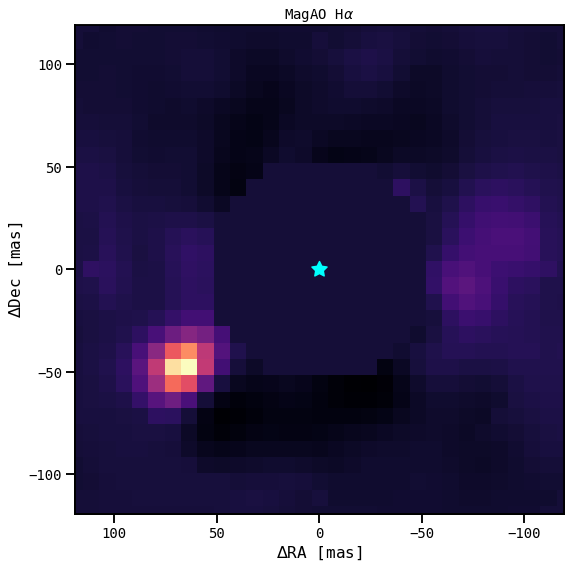

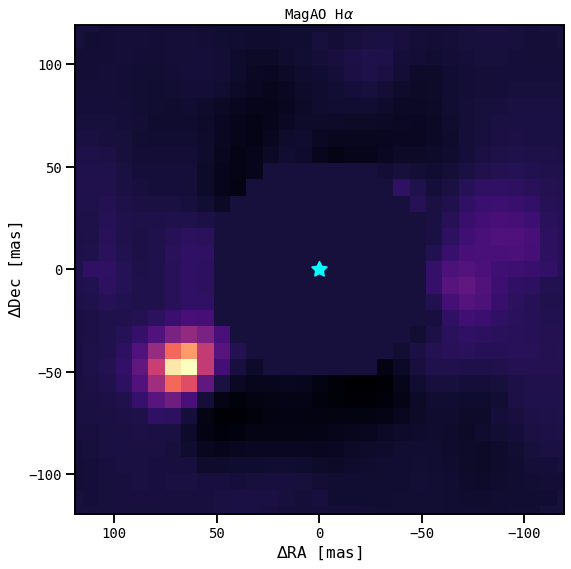

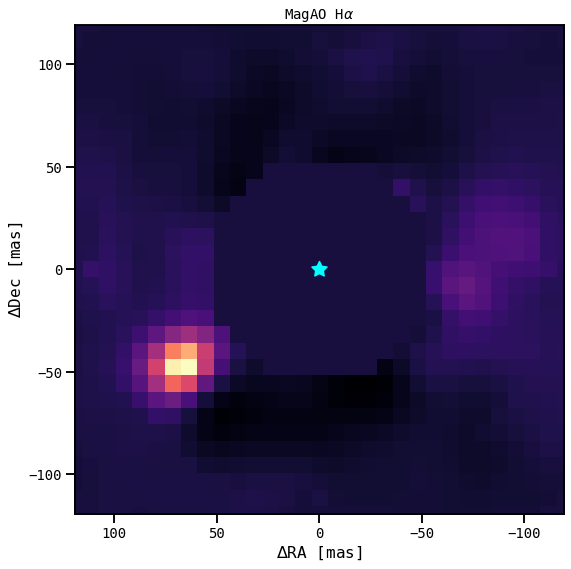

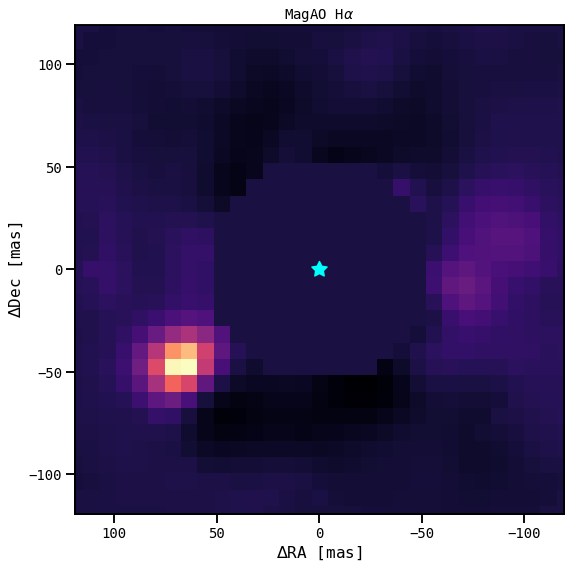

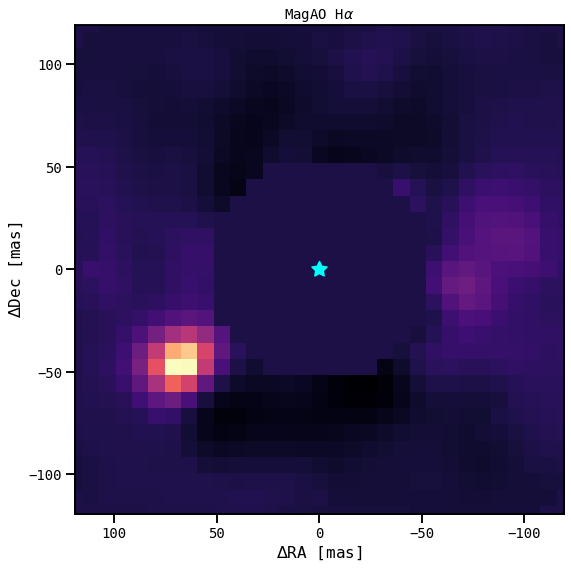

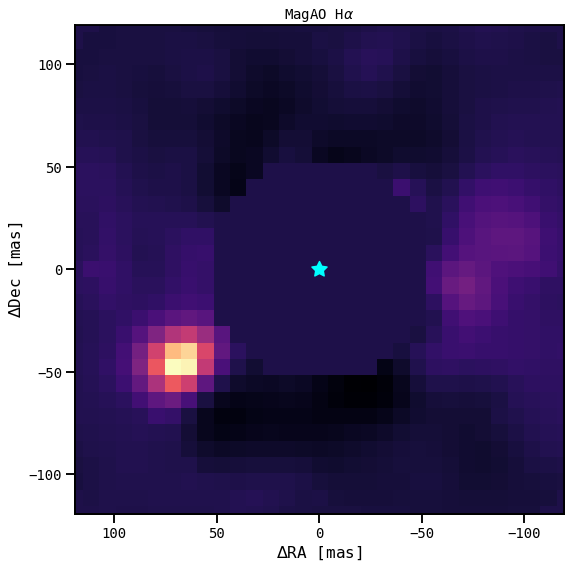

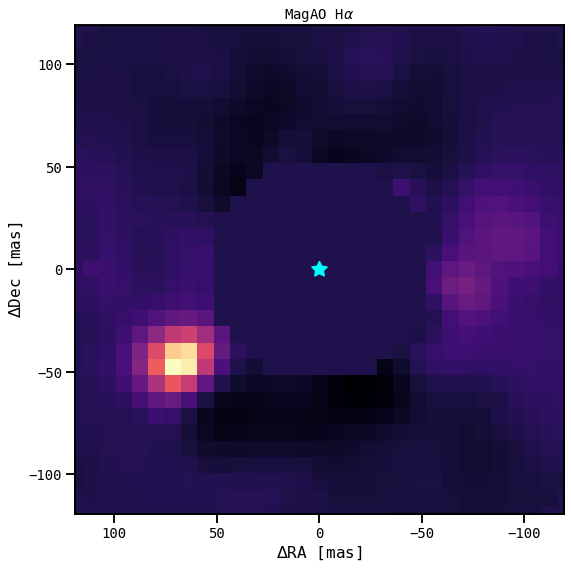

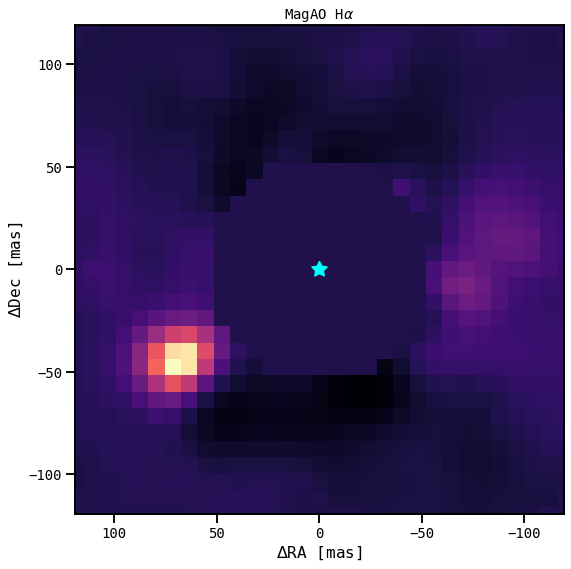

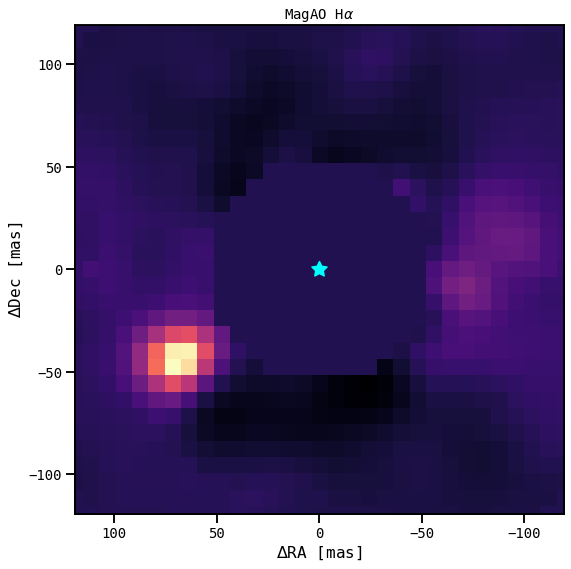

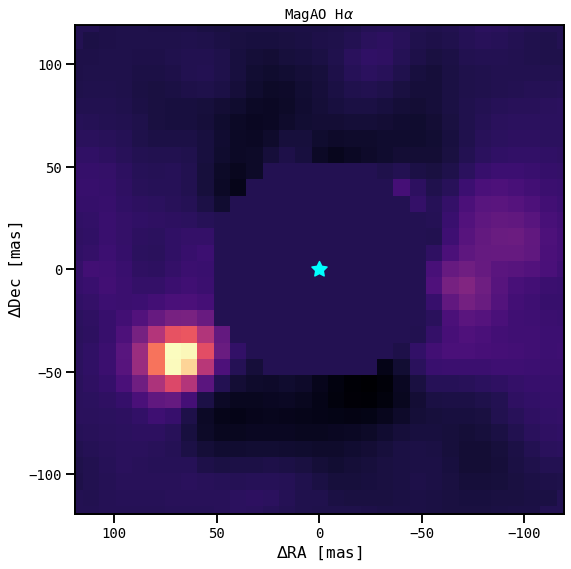

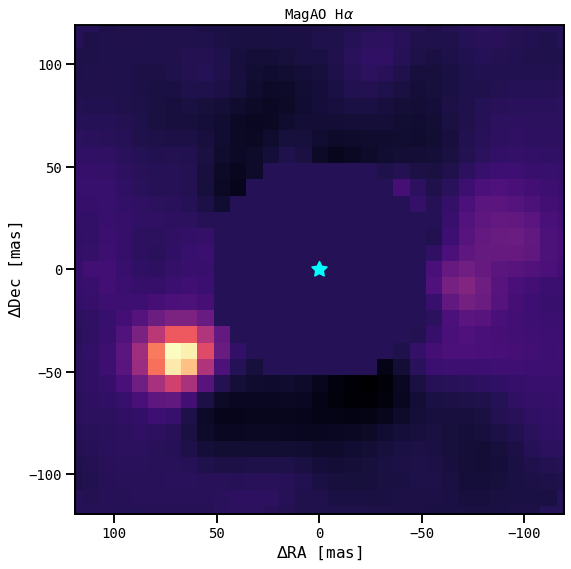

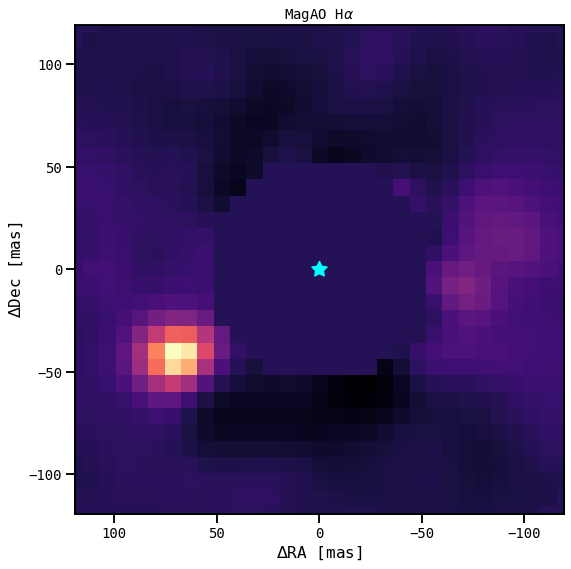

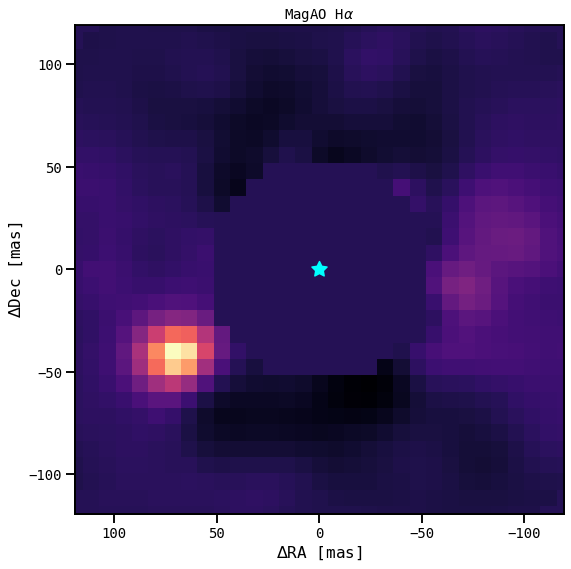

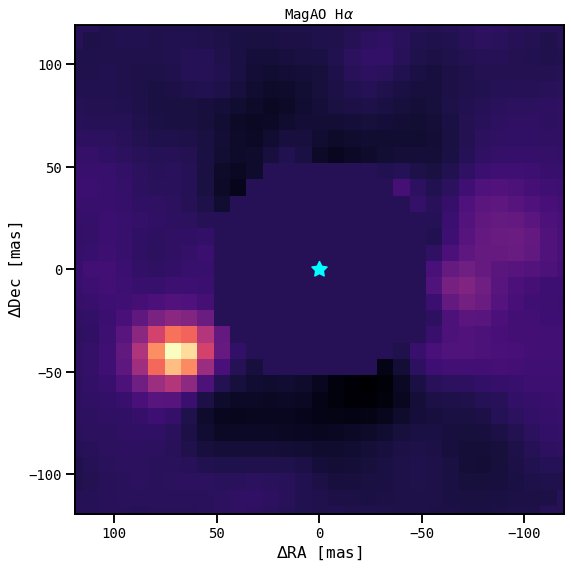

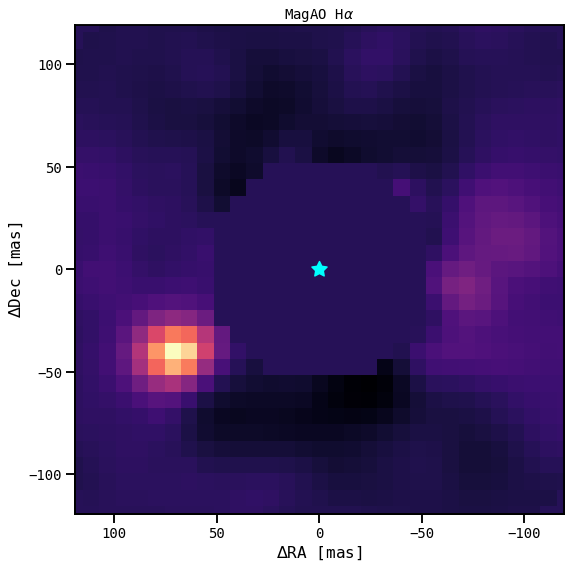

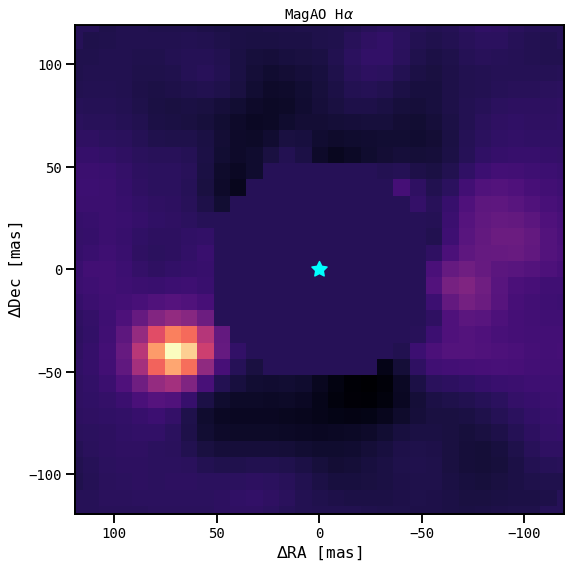

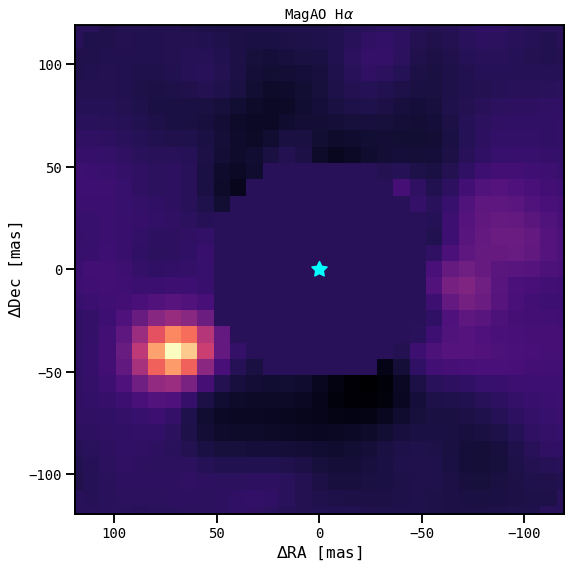

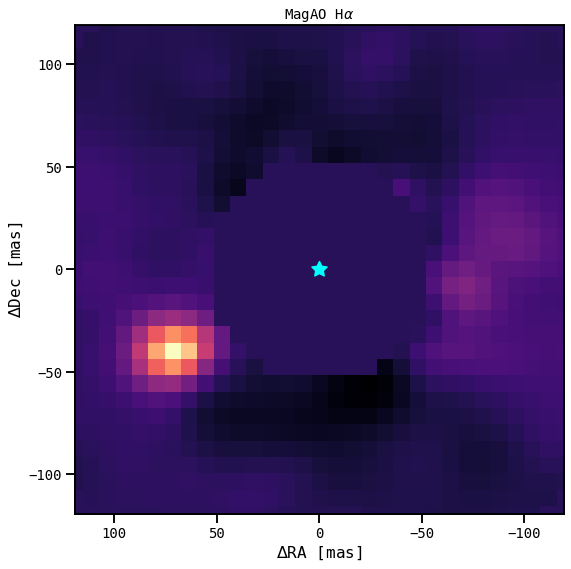

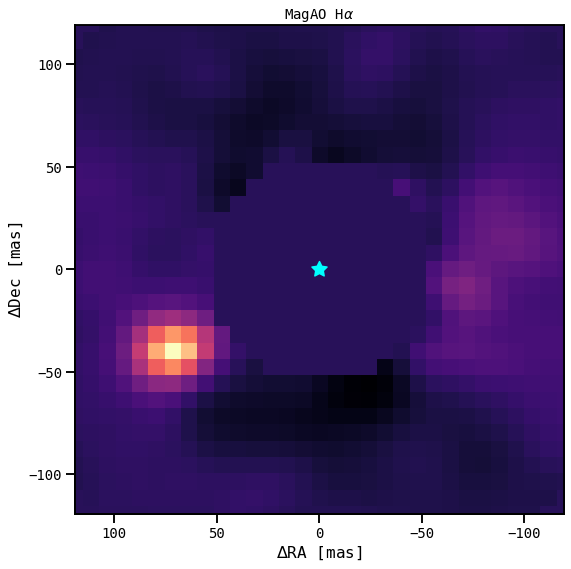

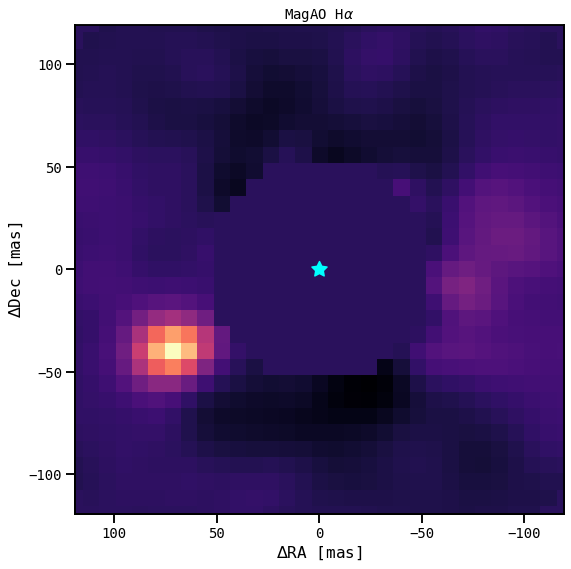

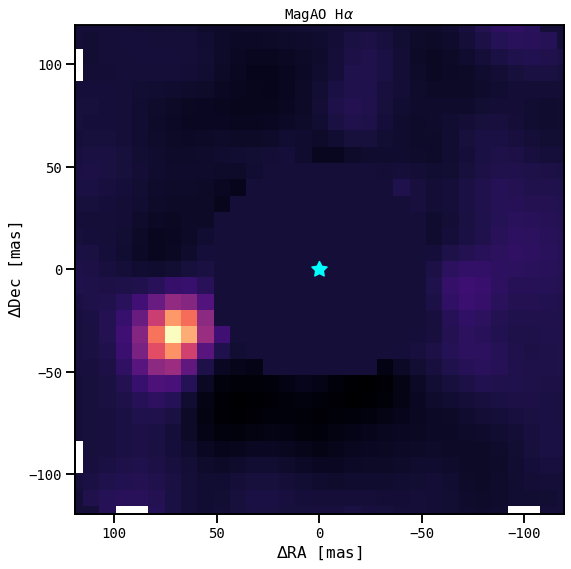

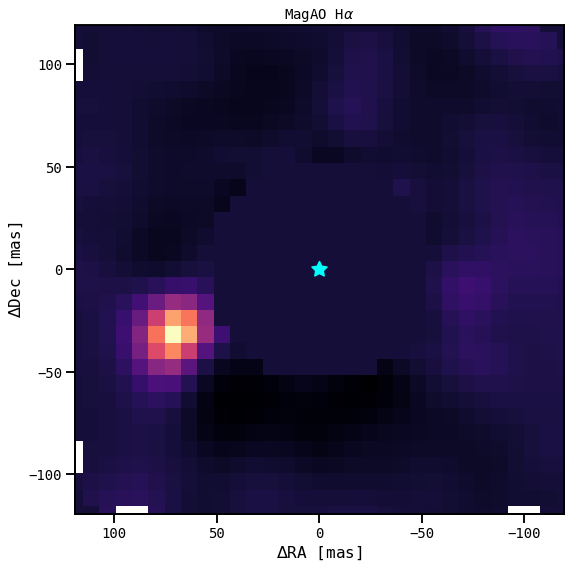

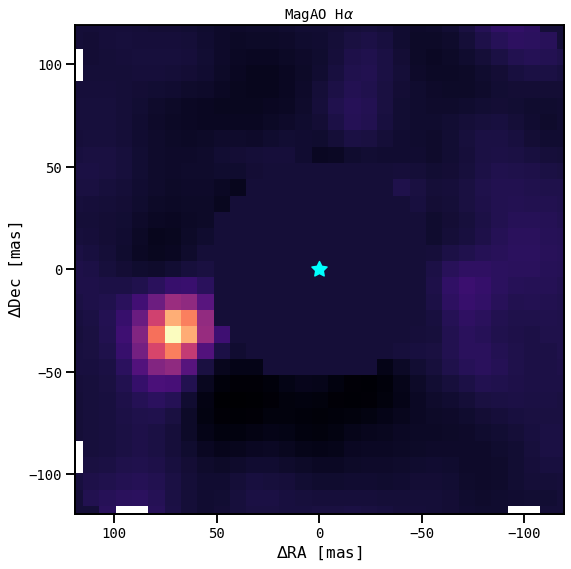

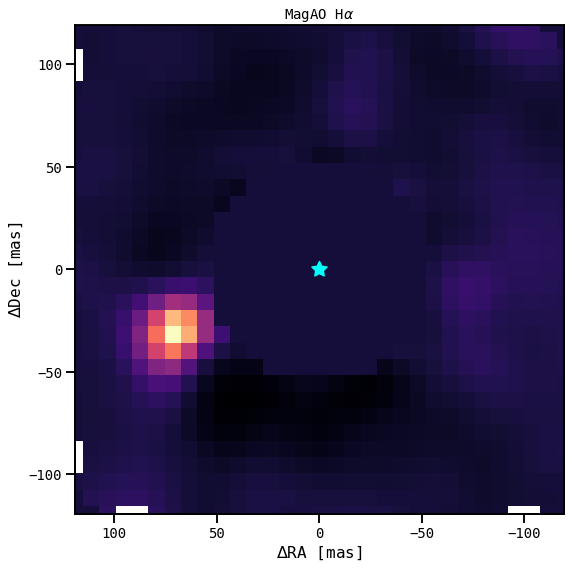

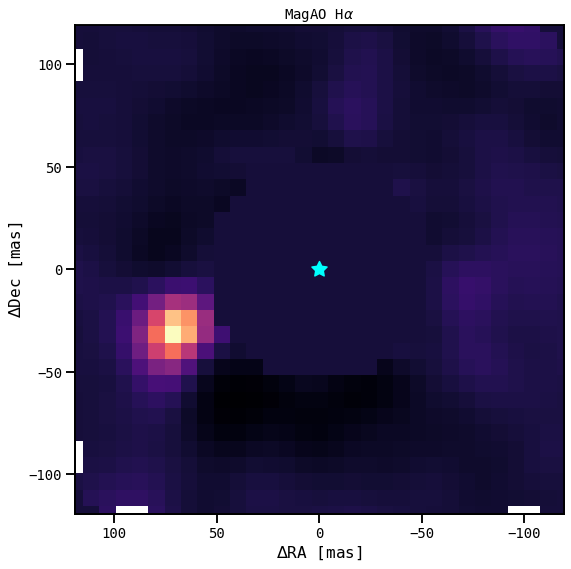

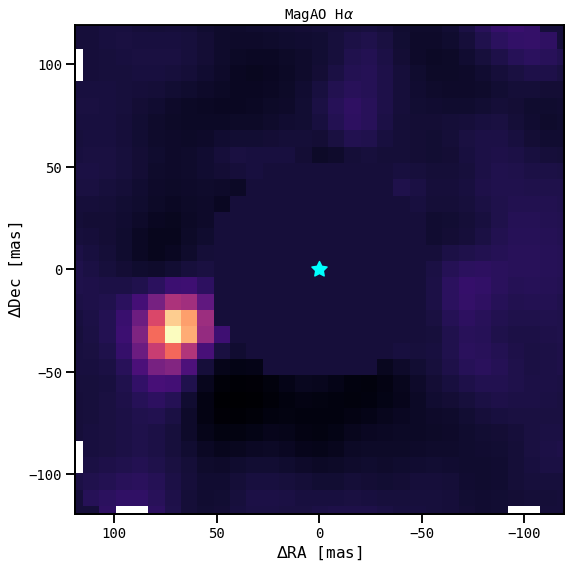

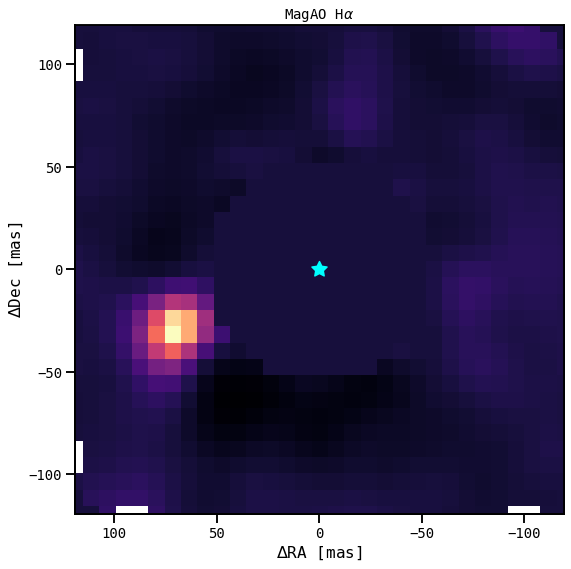

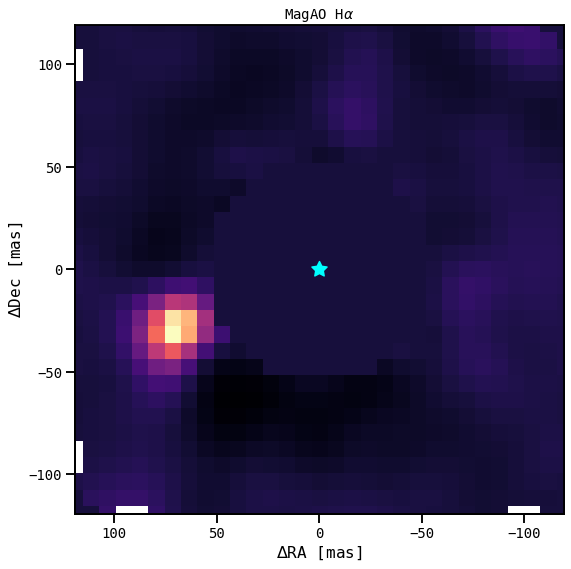

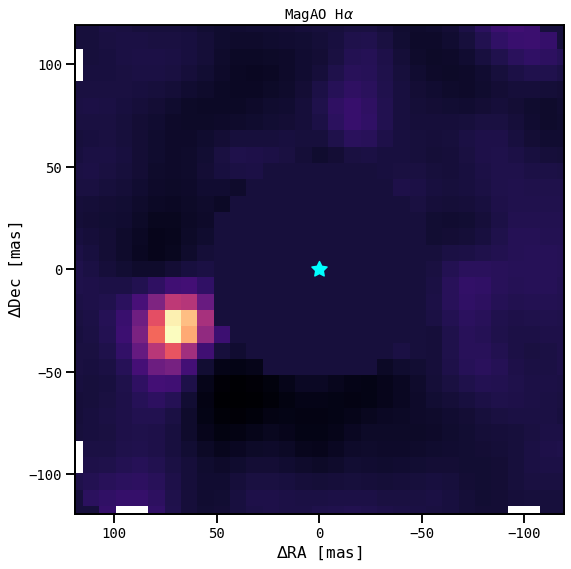

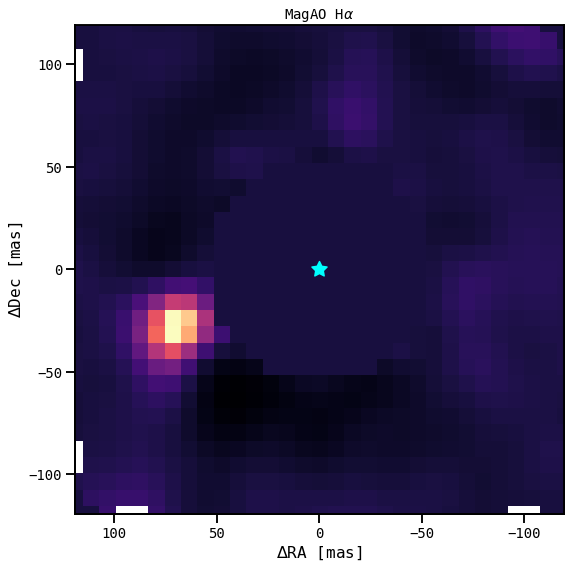

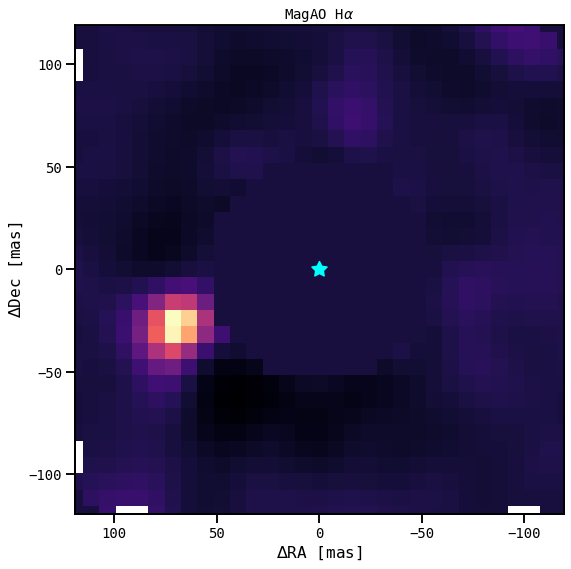

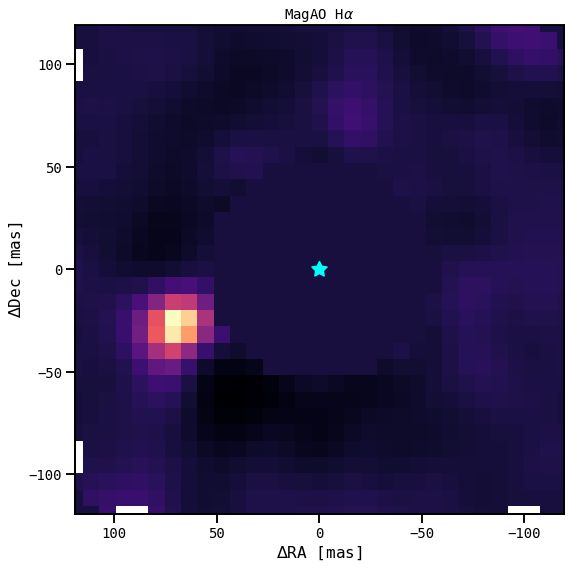

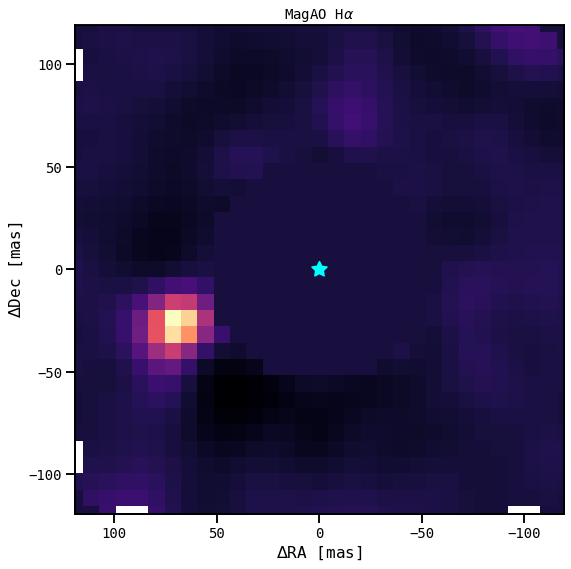

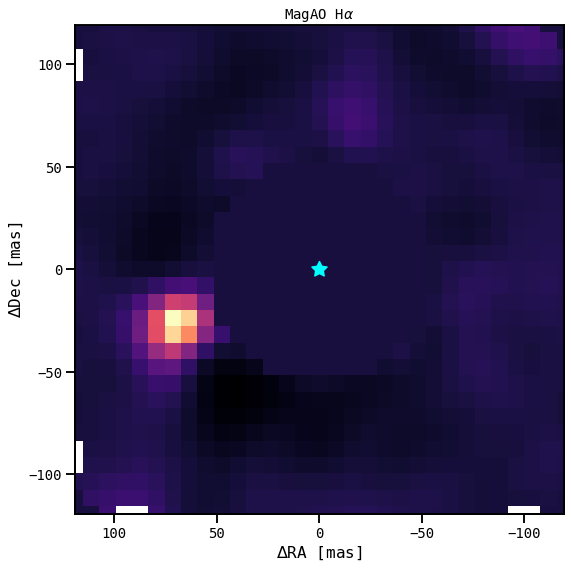

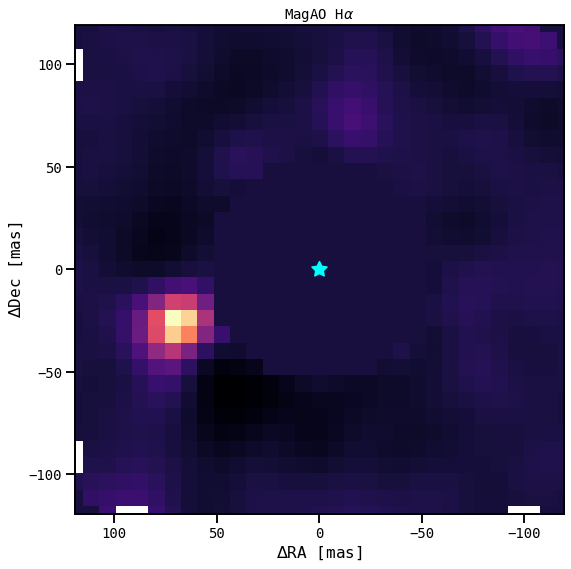

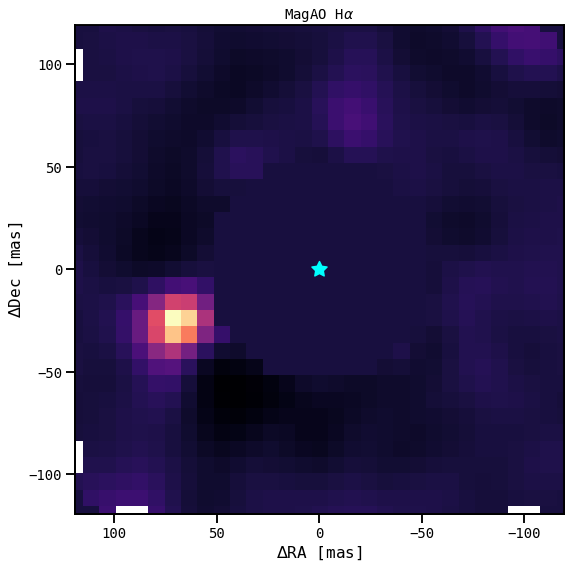

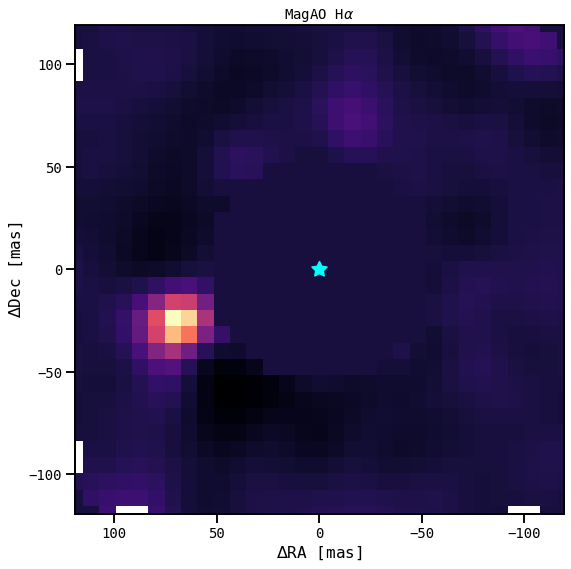

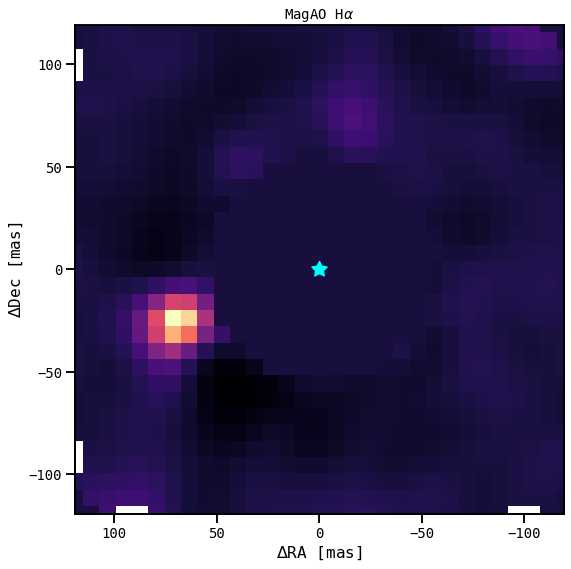

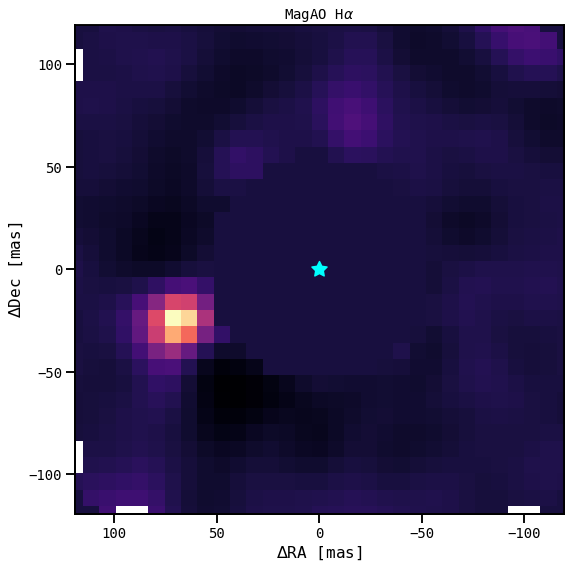

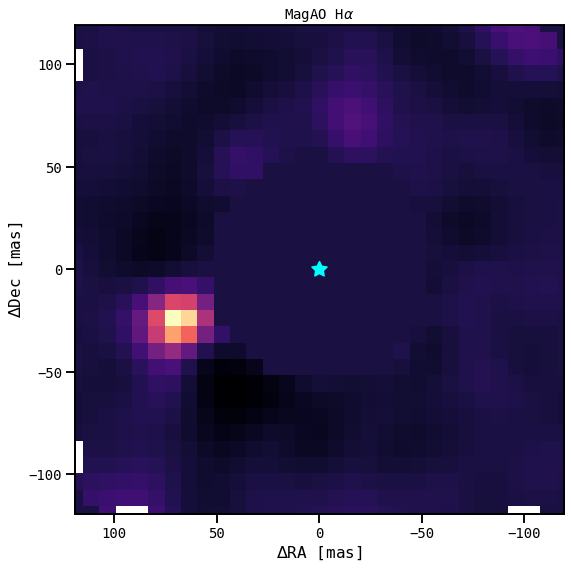

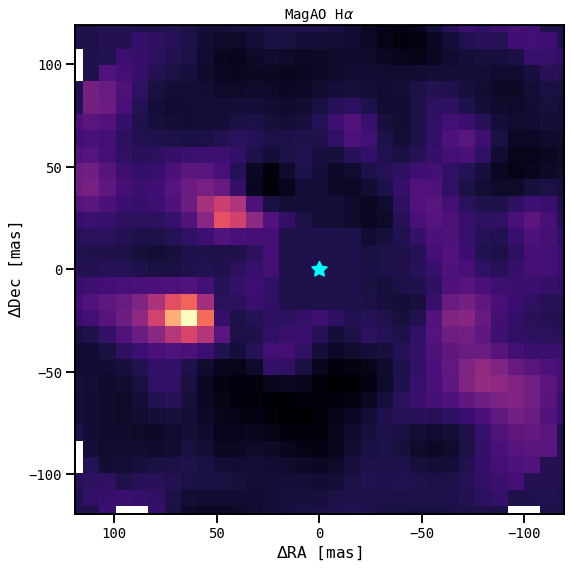

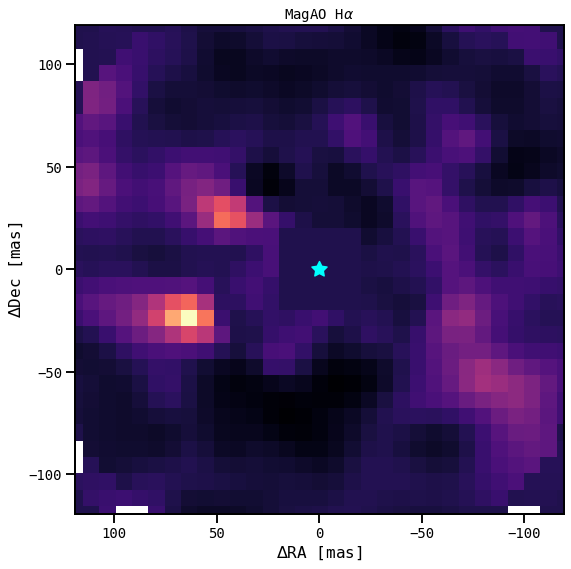

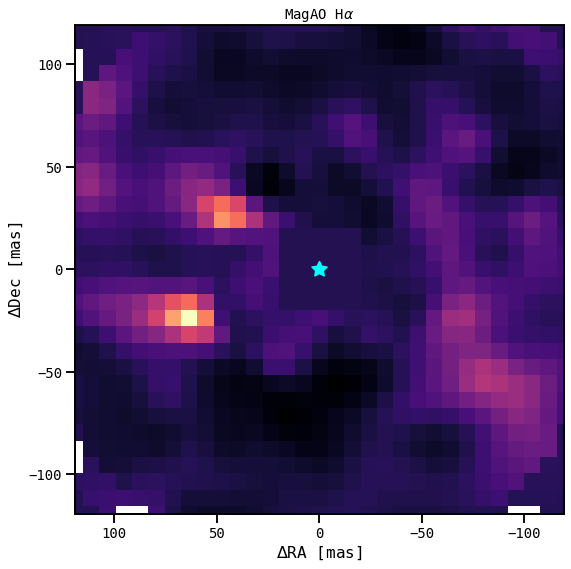

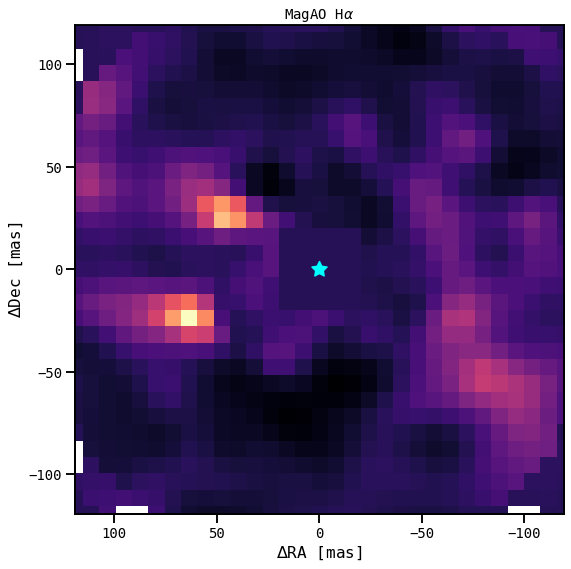

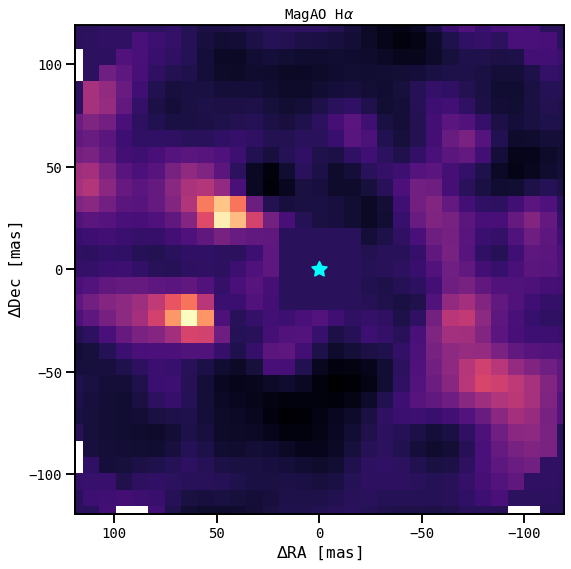

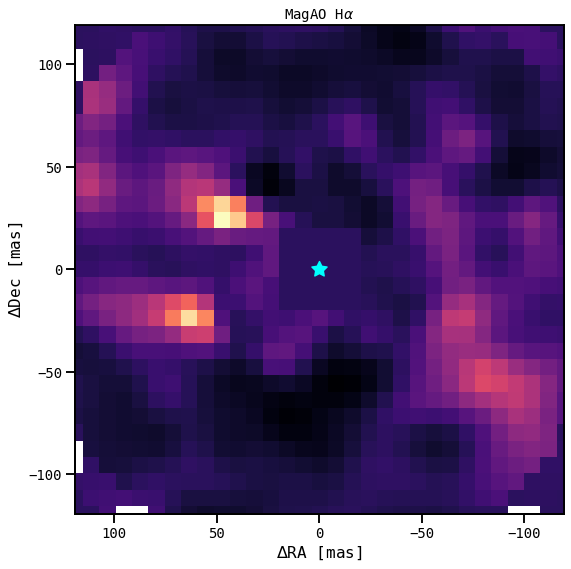

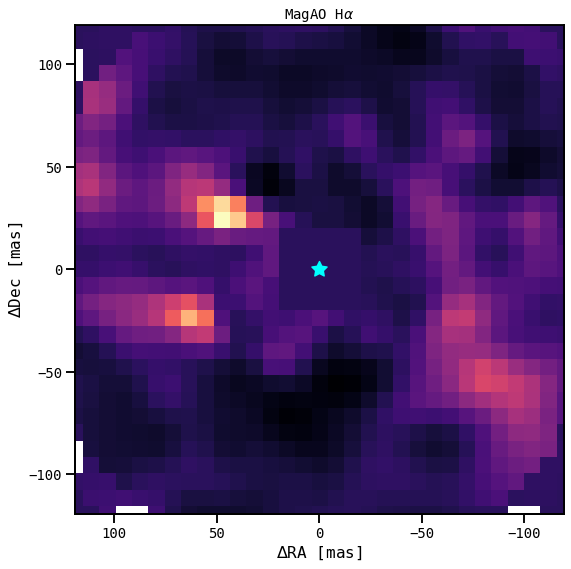

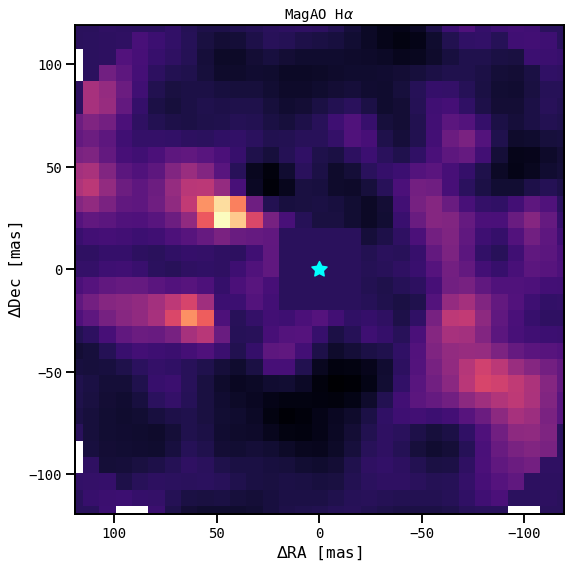

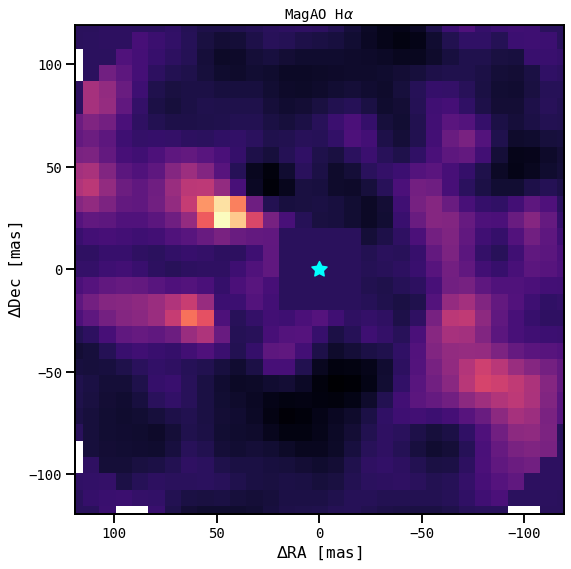

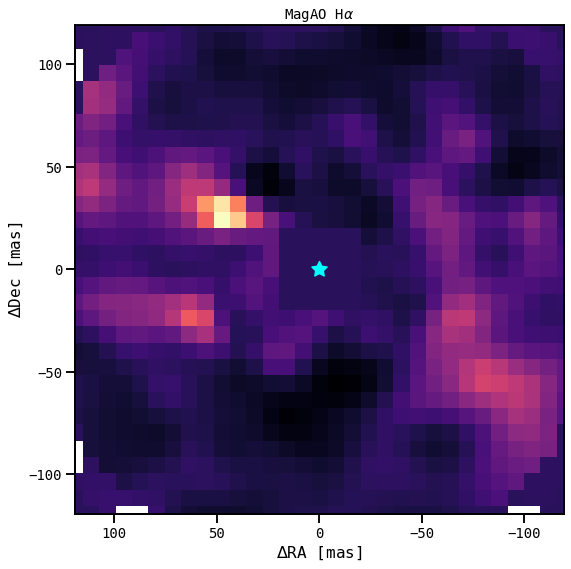

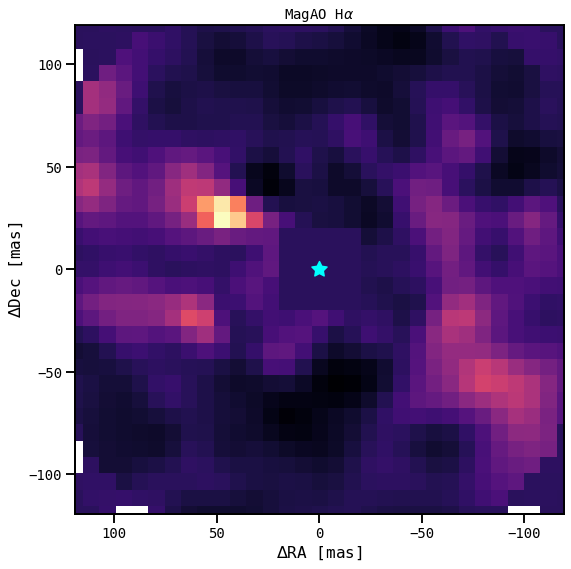

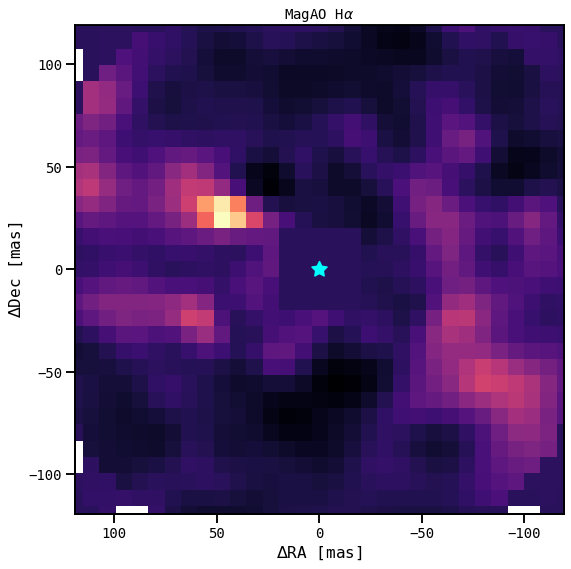

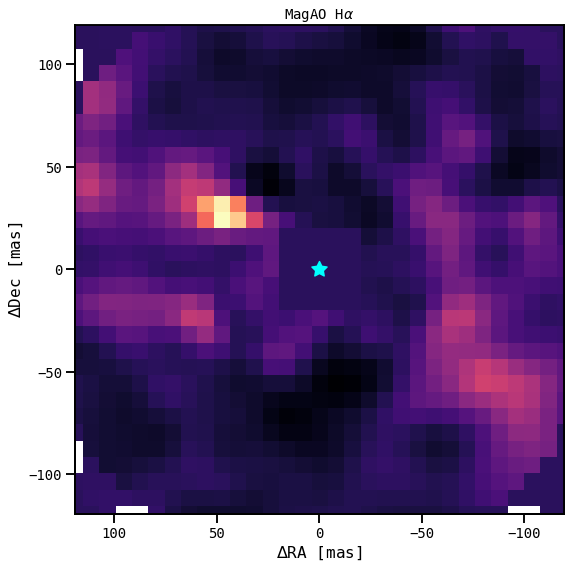

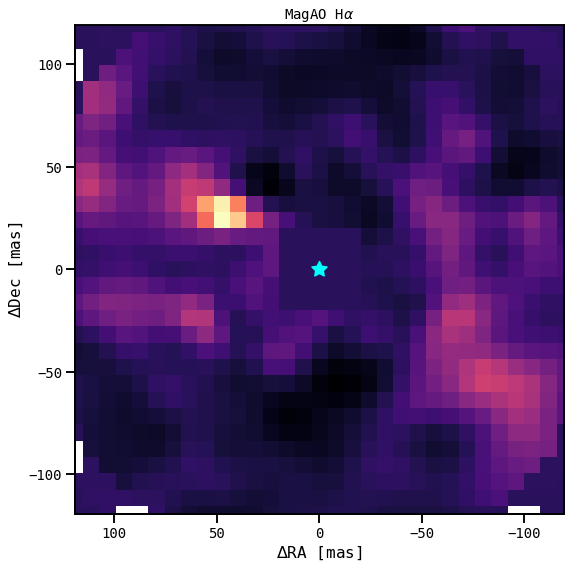

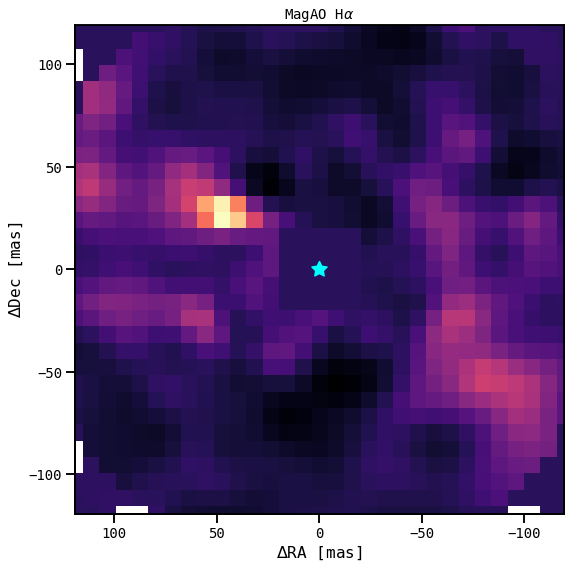

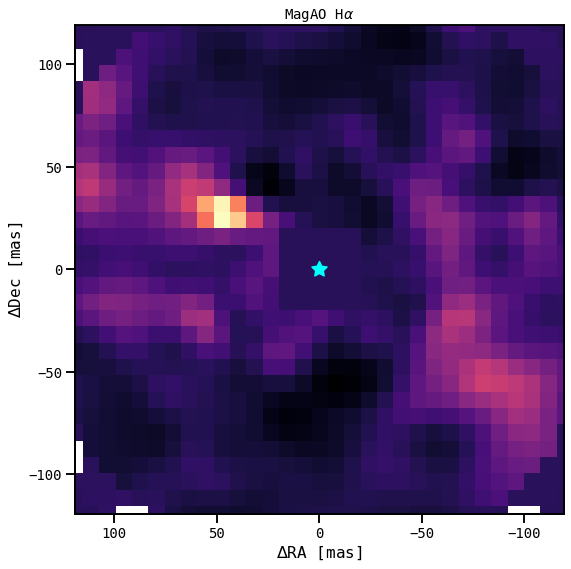

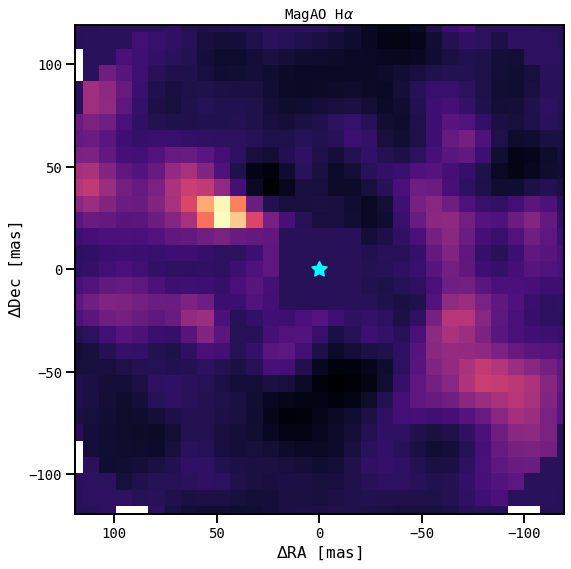

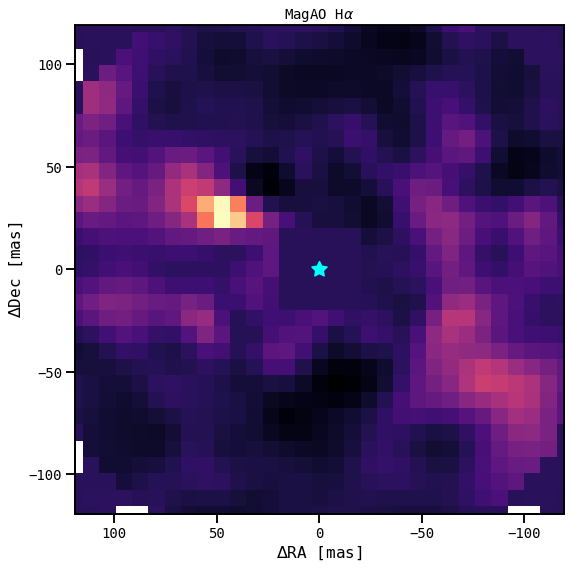

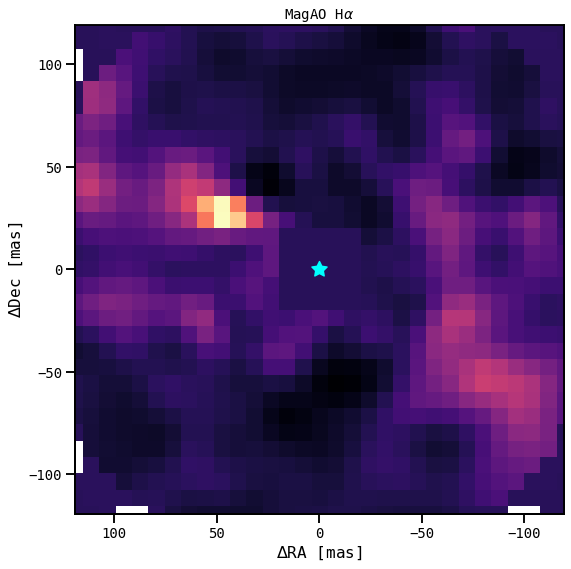

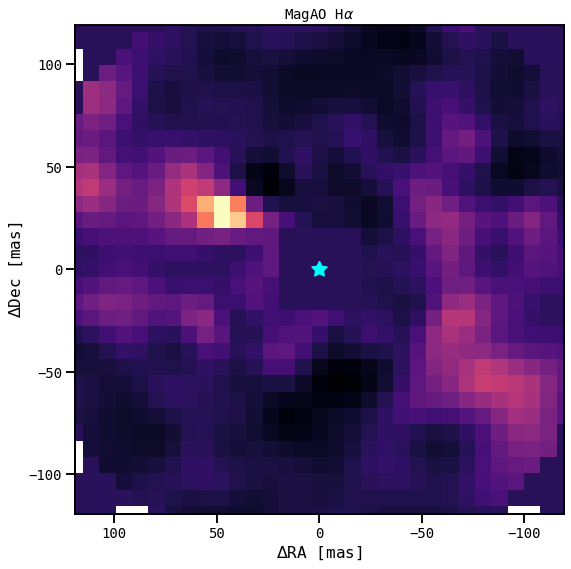

In [67]:
def interp_anim(img):
    fig, axs = plt.subplots(1,1, figsize=(9,9))
    fig.patch.set_alpha(0)
    axs.imshow(img, cmap='magma', norm=ImageNormalize(img, stretch=SinhStretch()), origin='lower')
    axs.scatter([225], [225], c='cyan', s=250, marker=(5, 1))
    axs.set_xlim(210,240)
    axs.set_ylim(210,240)
    axs.tick_params(axis='x',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False
                    )
    axs.tick_params(axis='y',
                    which='both',
                    left=False,
                    right=False,
                    labelleft=False
                    )
    secax = axs.secondary_xaxis('bottom', functions=(negpix2arc, negarc2pix))
    secay = axs.secondary_yaxis('left', functions=(pix2arc, arc2pix))
    secax.set_xlabel(r'$\Delta$RA [mas]')
    secay.set_ylabel(r'$\Delta$Dec [mas]')
    plt.xticks(rotation=45, ha="right", fontsize=20)
    plt.yticks(ha="right", fontsize=20)
    plt.title(r'MagAO H$\alpha$')

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

# kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./orbit_interp.mp4', [interp_anim(i) for i in interps], fps=24, quality=5)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (648, 648) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7f809527e000] Warning: data is not aligned! This can lead to a speed loss


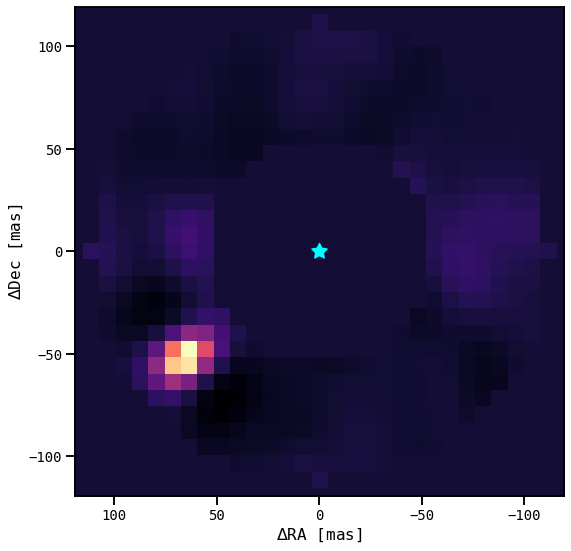

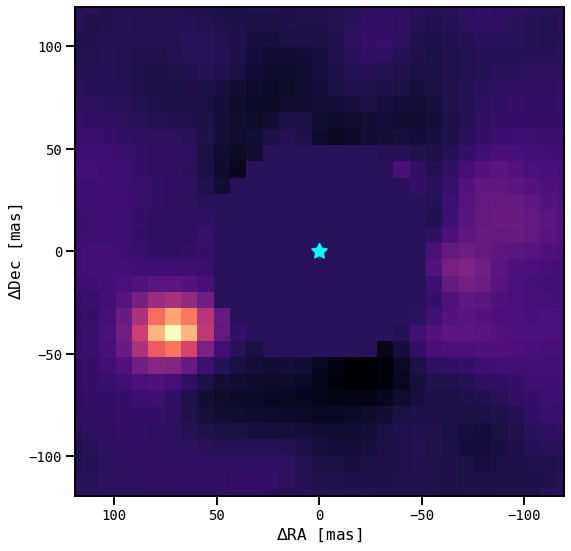

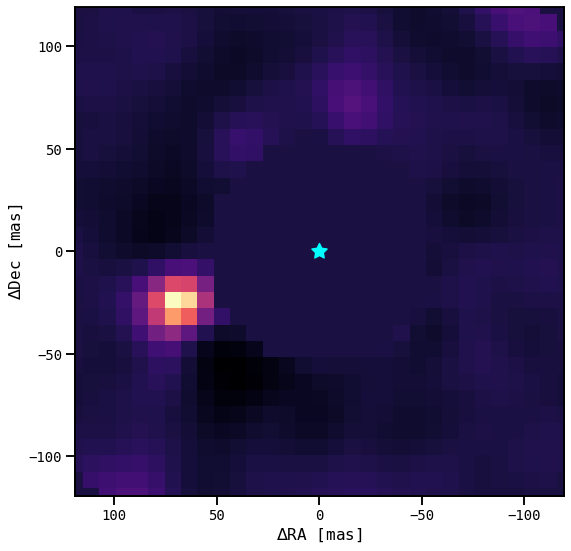

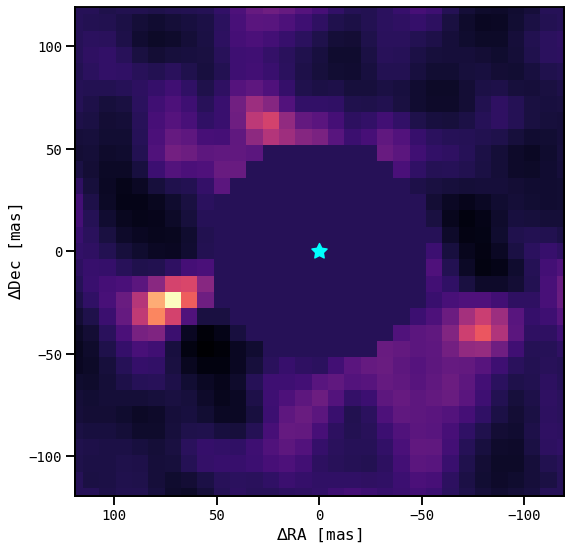

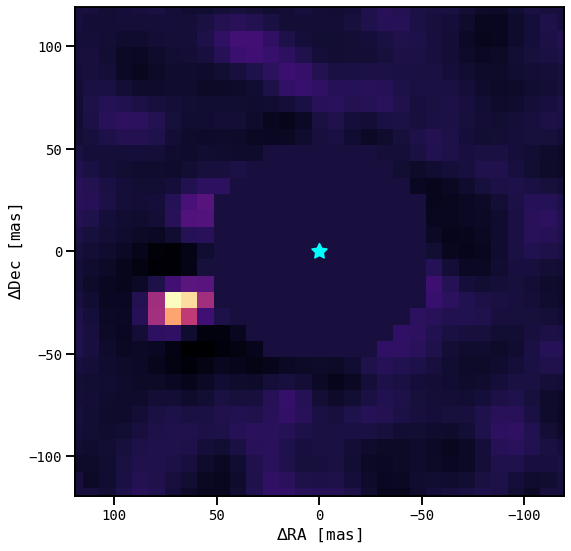

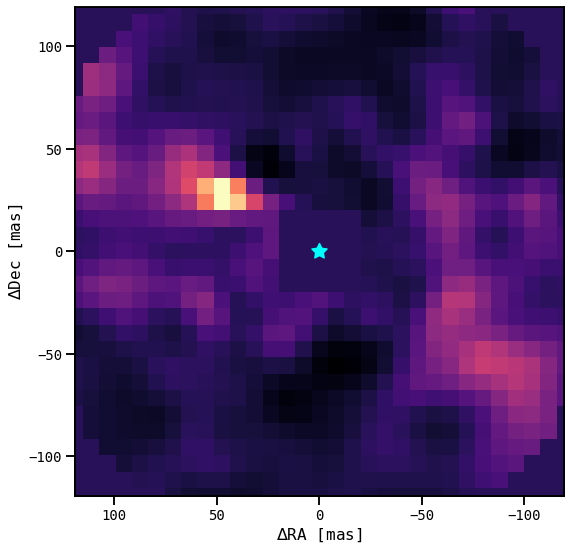

In [76]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def plot_for_offset(i, saveindiv=False, smooth=False):
    
    date = dates[i]
    output_prefix_orig = 'output/'+date+'/*'
    linefile, contfile = glob.glob(output_prefix_orig+'/doGaussian/*-klipped*.fits')
    inner, outer = innouttdict[date]
    xlim = (210,240)
    ylim = (210,240)
    line = fits.getdata(linefile)[0]        
    if smooth:
        line = nan_gaussian_filter(line, smooth)
    line = domask(line, inn=inner, outt=outer)
    line = line/np.nanmax(line)
    fig, axs = plt.subplots(1,1, figsize=(9,9))
    fig.patch.set_alpha(0)
    axs.imshow(line, interpolation='nearest', cmap='magma', norm=ImageNormalize(line, stretch=SinhStretch()), origin='lower')
    axs.scatter([225], [225], c='cyan', s=250, marker=(5, 1))
    axs.set_xlim(210,240)
    axs.set_ylim(210,240)
    axs.tick_params(axis='x',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False
                    )
    axs.tick_params(axis='y',
                    which='both',
                    left=False,
                    right=False,
                    labelleft=False
                    )
    secax = axs.secondary_xaxis('bottom', functions=(negpix2arc, negarc2pix))
    secay = axs.secondary_yaxis('left', functions=(pix2arc, arc2pix))
    secax.set_xlabel(r'$\Delta$RA [mas]')
    secay.set_ylabel(r'$\Delta$Dec [mas]')
#     apertures = CircularAperture(pixpreds[i], r=4)
#     apertures.plot(axes=axs, color='cyan', lw=3, alpha=0.5, zorder=11)
    plt.xticks(rotation=45, ha="right", fontsize=20)
    plt.yticks(ha="right", fontsize=20)
    plt.title(r'MagAO H$\alpha$ {}'.format(dates[i]))

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    if saveindiv is True:
        plt.savefig(dates[i]+'_orbit.png', dpi=300)

    return image

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./orbit.mp4', [plot_for_offset(i, saveindiv=True, smooth=1) for i in range(len(dates))], fps=1, quality=8)

output/11Apr13/*


ValueError: too many values to unpack (expected 2)

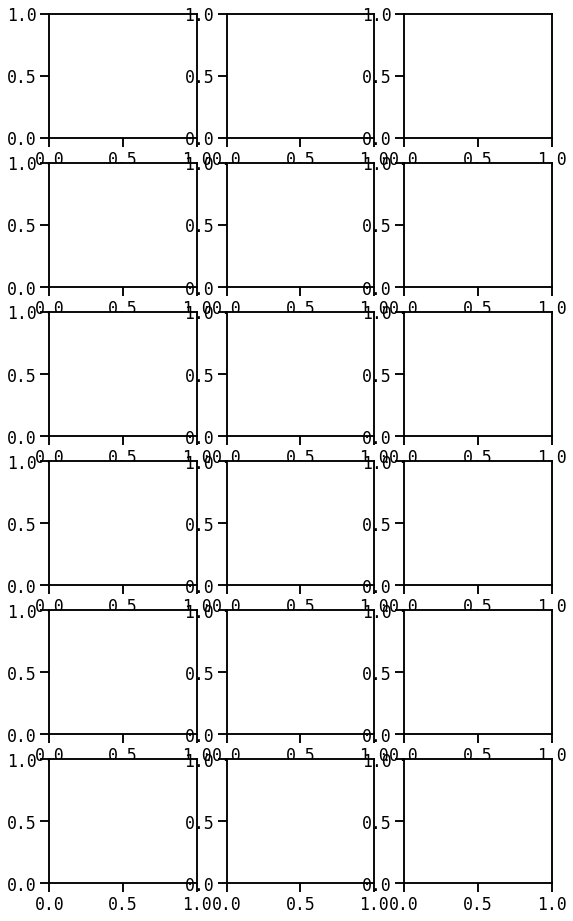

In [10]:
smooth = 1
cbarpad = 0.05
fig, axs = plt.subplots(6, 3, figsize=(9,16))
axs = trim_axs(axs, 6*3)
k = 0
predi = 0
for ax, i in zip(axs, range(len(axs))):
    j = i % 3
    date = dates[k]
    output_prefix_orig = 'output/'+date+'/*'
    print(output_prefix_orig)
    linefile, contfile = glob.glob(output_prefix_orig+'/doGaussian/*-klipped*.fits')
    inner, outer = innouttdict[date]
    xlim = (210,240)
    ylim = (210,240)
    if j == 0:
        line = fits.getdata(linefile)[0]        
        if smooth:
            line = nan_gaussian_filter(line, smooth)
        line = domask(line, inn=inner, outt=outer)
        im = ax.imshow(line, interpolation='nearest', cmap='magma', norm=ImageNormalize(line, stretch=SinhStretch()))
        if i == 0:
            ax.set_title(r"H$\alpha$, $\lambda=0.656$")
        divider = make_axes_locatable(ax)
        cax2 = divider.append_axes("right", size="5%", pad=cbarpad)
        cb2 = fig.colorbar(im, cax=cax2, ticks=[])
    elif j == 1:
        cont = fits.getdata(contfile)[0]
        if smooth:
            cont = nan_gaussian_filter(cont, smooth)
        cont = domask(cont, inn=inner, outt=outer)
        im = ax.imshow(cont, interpolation='nearest', cmap='magma', norm=ImageNormalize(line, stretch=SinhStretch()))
        divider = make_axes_locatable(ax)
        cax2 = divider.append_axes("right", size="5%", pad=cbarpad)
        lmax = np.nanmax(line)
        cb2 = fig.colorbar(im, cax=cax2, ticks=[0, lmax//2, int(lmax)])
        if i == 1:
            ax.set_title(r"Continuum, $\lambda=0.658$")
    elif j == 2:
        residual_map = (line)-(cont)
        im = ax.imshow(residual_map, interpolation='nearest', cmap='magma', norm=ImageNormalize(residual_map, stretch=SinhStretch()))
        if i == 2:
            ax.set_title(r"SDI (H$\alpha$ - Cont.)")
        divider = make_axes_locatable(ax)
#         cax4 = divider.append_axes("left", size="5%")
        cax3 = divider.append_axes("right", size="5%", pad=cbarpad)
        rmax = np.nanmax(residual_map)
        cb3 = fig.colorbar(im, cax=cax3, ticks=[0, rmax//2, int(rmax)])
        cb3.set_label("Counts")

    ax.scatter([225], [225], c='cyan', s=150, marker=(5, 1))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(axis='x',
                   which='both',
                   bottom=False,
                   top=False,
                   labelbottom=False
                   )
    ax.tick_params(axis='y',
                   which='both',
                   left=False,
                   right=False,
                   labelleft=False
                   )
    secax = ax.secondary_xaxis('bottom', functions=(negpix2arc, negarc2pix))
    secay = ax.secondary_yaxis('left', functions=(pix2arc, arc2pix))
    if i == 15:
        secax.set_xlabel(r'$\Delta$RA [mas]')
        secay.set_ylabel(r'$\Delta$Dec [mas]')
    else:
        secax.set(xticklabels=[])
        secay.set(yticklabels=[])
    apertures = CircularAperture(pixpreds[predi], r=4)
    apertures.plot(axes=ax, color='cyan', lw=1.5, alpha=1, zorder=11)
    
    if j == 2:
        k += 1
        predi += 1

ylabel_names = Reverse(dates)
ylabel_dict = {'x':-0.03,'y':np.arange(0.17,0.85,1/7.4),'color':'black'}
for i in range(len(ylabel_names)):
    plt.gcf().text(ylabel_dict['x'],ylabel_dict['y'][i], ylabel_names[i], fontsize=16, color=ylabel_dict['color'],
             transform=plt.gcf().transFigure,horizontalalignment='right'
            )
plt.rcParams['figure.constrained_layout.use'] = False
# plt.gcf().subplots_adjust(left=0.25)
# plt.savefig('SDI-results/SDI-gallery-new.pdf', bbox_inches="tight", dpi=300)

/var/folders/0q/4ls9h2fn4lv90qs43vdtzvkw0002tl/T/ipykernel_13132/3176849286.py:73: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im3 = ax3.imshow(residual_map, interpolation='nearest', cmap='magma', norm=ImageNormalize(stretch=SinhStretch()), vmin=-n2, vmax=n2)


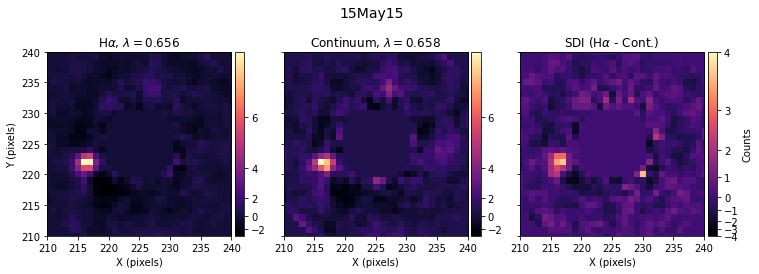

In [224]:
date = dates[2]
output_prefix_orig = 'output/'+date+'/*'
linefile, contfile = glob.glob(output_prefix_orig+'/doGaussian/*-klipped*.fits')
cont = fits.getdata(contfile)[0]
line = fits.getdata(linefile)[0]

totalresidmap = line-cont

# line[np.isnan(line)] = np.nanmedian(line)
# cont[np.isnan(cont)] = np.nanmedian(cont)

smooth = False

if smooth:
    line = nan_gaussian_filter(line, 1)
    cont = nan_gaussian_filter(cont, 1)

inner = 6
outer = 18

xlim = (210,240)
ylim = (210,240)

line = domask(line, inn=inner, outt=outer)
cont = domask(cont, inn=inner, outt=outer)

# scale is one bc we don't need to prove this isn't disk signal
scale = 1#scalefactordict[date]

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch, SinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize

fig = plt.figure(figsize=(12, 4))

# make residual map
residual_map = (line)-(cont)#*scale)
residual_map = residual_map#/np.nanstd(residual_map)

# normalize all images to same scale
colornorm = matplotlib.colors.Normalize(vmin=np.nanpercentile(line, 0.03),
                                        vmax=np.nanpercentile(line, 99.7))

# plot the data_stamp
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(line, interpolation='nearest', cmap='magma', norm=ImageNormalize(stretch=SinhStretch()))
ax1.invert_yaxis()
ax1.set_title(r"H$\alpha$, $\lambda=0.656$")
ax1.set_xlabel("X (pixels)")
ax1.set_ylabel("Y (pixels)")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = fig.colorbar(im1, cax=cax1)#, ticks=[-500, 0, 500])

ax2 = fig.add_subplot(132)
im2 = ax2.imshow(cont, interpolation='nearest', cmap='magma', norm=ImageNormalize(stretch=SinhStretch()))
ax2.invert_yaxis()
ax2.set(yticklabels=[])
ax2.set_title(r"Continuum, $\lambda=0.658$")
ax2.set_xlabel("X (pixels)")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cb2 = fig.colorbar(im1, cax=cax2)#, ticks=[-500, 0, 500])

ax3 = fig.add_subplot(133)
n2 = 4#np.nanmax(residual_map)
im3 = ax3.imshow(residual_map, interpolation='nearest', cmap='magma', norm=ImageNormalize(stretch=SinhStretch()), vmin=-n2, vmax=n2)
ax3.invert_yaxis()
ax3.set(yticklabels=[])
ax3.set_title(r"SDI (H$\alpha$ - Cont.)")
ax3.set_xlabel("X (pixels)")
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)

divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
cb3 = fig.colorbar(im3, cax=cax3)#, ticks=[-n2, 0, n2])
cb3.set_label("Counts")

fig.suptitle(date, size=14)
plt.savefig('SDI-results/'+date+'-SDI.png', transparent=True, dpi=300)

In [225]:
residual_map = residual_map[ylim[0]:ylim[1],xlim[0]:xlim[1]]

In [234]:
y0,y1 = 8,18
x0,x1 = 2,12
peak = np.nanmax(residual_map[y0:y1,x0:x1])
std = np.nanstd(domask(totalresidmap, inn=16, outt=18)[200:250,225:250])
print(peak, std)
print('ASDI SNR is...',str(peak/std))

3.6886538571132417 0.1149932234987913
ASDI SNR is... 32.077141112163126


(2.0, 12.0)

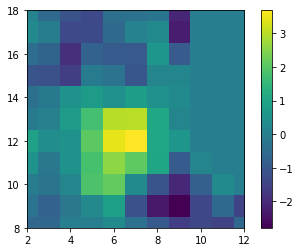

In [227]:
residual_map = domask(residual_map, inn=inner)
plt.imshow(residual_map, origin='lower')
plt.colorbar()
plt.ylim(8,18)
plt.xlim(2,12)

In [229]:
np.nanstd(domask(totalresidmap, inn=14, outt=18)[200:250,225:250])

0.16703264932429068

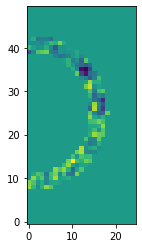

In [228]:
plt.imshow(domask(totalresidmap, inn=14, outt=18)[200:250,225:250], origin='lower')
# plt.xlim(200,250)
# plt.ylim(200,250)